# Theory

## Tree-Based Methods

### Regression Trees

Decision trees stratifies or segments the predictor space into a number of simple regions. To make predictions or classifications, we typically use the mean or the mode of the values of the observations/training data in the predictor region. It can be visualized by the following plot.

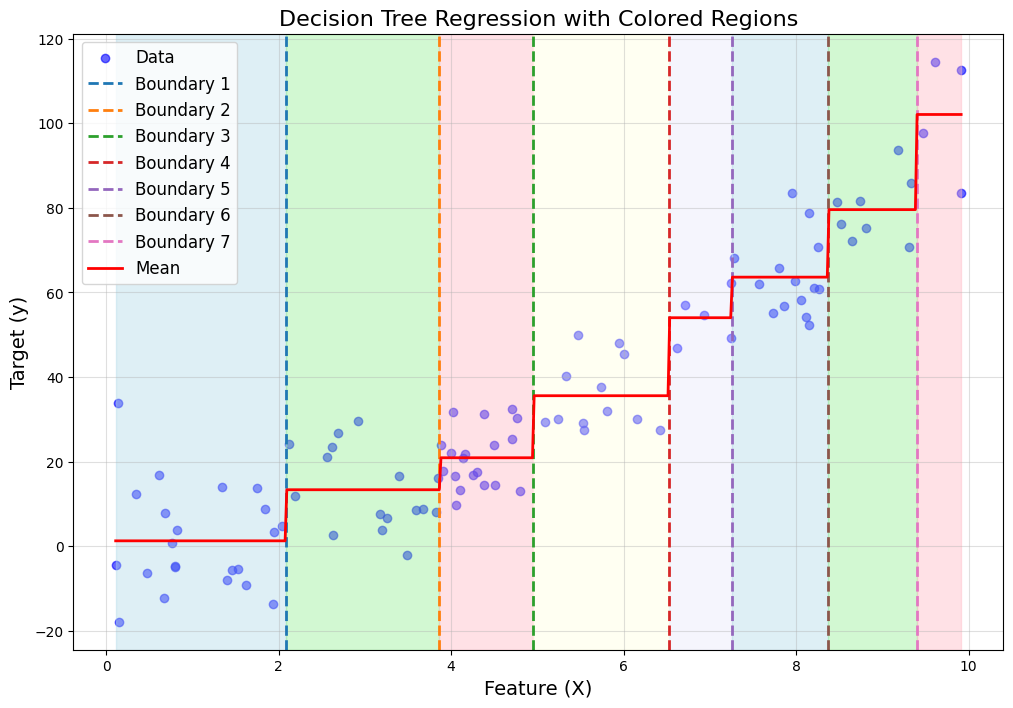

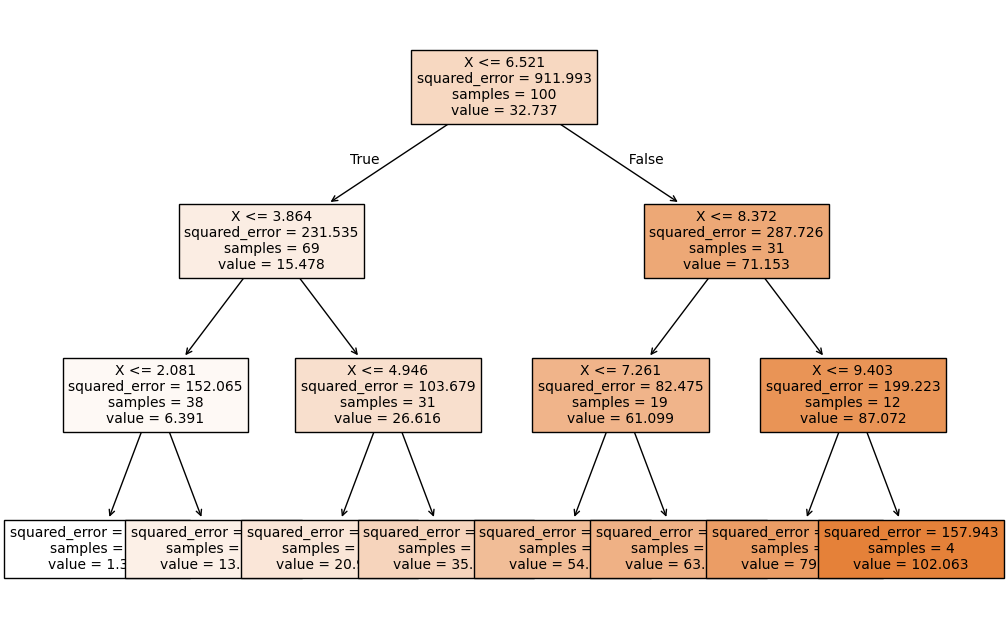

In [1]:
from regtree_vis import vis_regtree
vis_regtree()

The regression tree is constructed by dividing the predictor space into into distinct and non-overlapping regions, $R_j$, which is then characterized by the mean/mode or mean response of the values of all the observation within that region. In finding these regions, it would be computationally expensive and impossible, especially when working with high-dimensional rectangles, to check for every combination of regions that minimizes the Residual Sum of Squares given by $$\sum_{j = 1}^J \sum_{i \in R_j} (y_i - \hat y_{R_j})^2$$ where $\hat y_{R_j}$ is the mean response for the training observations in the jth region.

#### Recursive Binary Splitting

*Recursive Binary Splitting* is an approach used to create regression trees. It is a greedy top-down approach that begins with one predictor space and picks the best split that minimizes the RSS,  then repeats this on the smaller predictor space until a limiting parameter is reached. It splits the predictor regions into $\{X|X_j < s\}$ and $\{X|X_j \ge s\}$ where $s$ is the cut point of the predictor $X_j$ such that it has the smallest value for the RSS in that iteration. In other words, for every $j$ and $s$, we define the pair of half-planes $$R_1(j,s) = \{X|X_j < s\} \text{ and } R_2(j,s) = \{X|X_j \ge s\}$$ we then choose $j,s$ that minimizes the values of $$\sum_{i:x_i \in R_1(j,s)}(y_i - \hat{y}_{R_1})^2 + \sum_{i:x_i \in R_2(j,s)}(y_i - \hat{y}_{R_2})^2$$ where $\hat{y}_{R_1}$ is the mean response for the training observations in $R_1(j,s)$ and $\hat{y}_{R_2}$ is the mean response for the training observations in $R_2(j,s)$. If the region cannot be split further, we call them terminal nodes (leafs), and internal nodes (leafs) otherwise. Also, if two nodes, say $\sigma, \delta$ was a result of splitting a larger node (larger in the sense that it contains more of data that belonged to it), say $\gamma$, then we say that $\gamma$ is the parent node of nodes $\sigma, \delta$ or that nodes $\sigma, \delta$ are the child nodes of $\gamma$, and if the node does not have a parent but is not a terminal node, we call it the root node. When we evaluate a regression tree, we usually get the mean response of the terminal nodes the input belongs in.\
 **This approach is greedy because it only chooses the split that minimizes the RSS every iteration and does not take the RSS of the final tree into consideration.** 

#### Recursive Binary Splitting From Scratch
 The code below demonstrates a way on how we can build regression trees from scratch.

In [2]:
import pandas as pd
import numpy as np

class Node:
    def __init__(self, X: pd.DataFrame, y: pd.Series,
                 is_Terminal: bool = True, split: float = None, feature: str = None,
                 lt_node=None, gte_node=None,  
                 parent=None, depth: int = 0,
                 generate: bool = False, max_depth: float = float('inf'), min_points: int = 1):
        self.X = X
        self.y = y
        self.mean = y.mean()
        self.err = np.sum((y - self.mean)**2)
        self.is_Terminal = is_Terminal
        self.split = split
        self.feature = feature
        self.lt_node = lt_node
        self.gte_node = gte_node
        self.parent = parent
        self.depth = depth
        self.generate = generate
        self.max_depth = max_depth
        self.min_points = min_points
        # This allows nodes to recursively generate children nodes until the max_depth or the min_points has been reached.
        if self.generate and self.depth <= self.max_depth and self.X.shape[0] >= self.min_points:
            self.create_child(generate=self.generate, max_depth=self.max_depth, min_points=self.min_points)

    def add_Nodes(self, lt_node, gte_node):
        self.lt_node = lt_node
        self.gte_node = gte_node
        self.lt_node.parent = self
        self.gte_node.parent = self
        self.is_Terminal = False

    def evaluate_point(self, features):
        if self.is_Terminal:
            return self.mean
        else:
            if features[self.feature] < self.split:
                return self.lt_node.evaluate_point(features)
            else:
                return self.gte_node.evaluate_point(features)

    def create_child(self, generate: bool = False, max_depth: float = float('inf'), min_points: int = 1):
        def feature_best_split(X, y):
            X_sorted, y_sorted = np.array(X), np.array(y)

            best_sse = float('inf')
            best_split = None
            for i in range(1, len(X_sorted)):
                s = (X_sorted[i-1] + X_sorted[i]) / 2  # Candidate split point
                left_mask = X_sorted <= s
                right_mask = X_sorted > s

                y_left, y_right = y_sorted[left_mask], y_sorted[right_mask]

                if len(y_left) == 0 or len(y_right) == 0:
                    continue  # Skip empty splits

                sse = np.sum((y_left - y_left.mean())**2) + np.sum((y_right - y_right.mean())**2)

                if sse < best_sse: # Getting the best split that minimizes the SSE for that particular feature
                    best_sse, best_split = sse, s
            return best_split, best_sse

        def best_split(X: pd.DataFrame, y: pd.Series):
            best_sse = float('inf')
            best_s = None
            best_feature = None
            for feature in X.columns:
                X_sorted = X.sort_values(by=feature)
                split, sse = feature_best_split(X_sorted[feature], y[X_sorted.index])
                if sse < best_sse: # Getting the best split among all features that minimizes the SSE
                    best_sse, best_s, best_feature = sse, split, feature
            return best_sse, best_s, best_feature

        _, best_s, best_feature = best_split(self.X, self.y)

        if best_s is not None and best_feature is not None:
            self.split = best_s
            self.feature = best_feature

            lt_mask = self.X[best_feature] < best_s
            gte_mask = self.X[best_feature] >= best_s

            lt_X, lt_y = self.X[lt_mask], self.y[lt_mask]
            gte_X, gte_y = self.X[gte_mask], self.y[gte_mask]

            if len(lt_X) > self.min_points and len(gte_X) > self.min_points:
                lt_node = Node(X=lt_X, y=lt_y, depth=self.depth + 1,
                               generate=generate, max_depth=max_depth, min_points=min_points)
                gte_node = Node(X=gte_X, y=gte_y, depth=self.depth + 1,
                                generate=generate, max_depth=max_depth, min_points=min_points)
                self.add_Nodes(lt_node=lt_node, gte_node=gte_node)

    def generate_children(self, max_depth: float, min_points: int):
        if self.is_Terminal:
            self.create_child(generate=True, max_depth=max_depth, min_points=min_points)

class Tree:
    def __init__(self, root_node: Node = None, X: pd.DataFrame = None, y: pd.Series = None):
        self.root_node = root_node       
        self.X = X
        self.y = y
        self.features = None
        self.depth = None
        self.err = float('inf') # The training SSE of the tree
        self.residuals = None
        if self.y is not None:
            self.get_features()

    def load_data(self, X: pd.DataFrame, y: pd.Series):
        if self.X is None:
            self.X = X
            self.y = y
        else:
            print("Data has already been loaded!")

    def create_root_node(self):
        if self.root_node is None:
            if self.X is None:
                print("Load the data first!")
            else:
                self.root_node = Node(X=self.X, y=self.y)
        else:
            print("The tree already has a root node!")

    def evaluate(self, feature_set: pd.DataFrame):
        if self.root_node is None:
            print("Generate a tree first!")
        else:
            predictions = []
            for _, features in feature_set.iterrows():
                predictions.append(self.root_node.evaluate_point(features))
            return np.array(predictions)
        
    def get_features(self):
        self.features = self.X.columns.tolist()

    def calculate_error(self):
        self.err = np.sum((self.y - self.evaluate(self.X))**2)

    def calculate_residuals(self):
        self.residuals = self.y - self.evaluate(self.X)

    def generate_tree(self, max_depth: float = float('inf'), min_points: int = 1):
        if self.root_node is None:
            self.create_root_node()
        self.root_node.generate_children(max_depth=max_depth, min_points=min_points)
        # self.calculate_error()
        # self.calculate_residuals()



Trying the code to fit a synthetically generated dataset from the function $$y = 2X_1^2 + 3\cos(X_2) + \epsilon$$ where $y$ is the target variable and $X_1,X_2$ are features and $\epsilon \sim N(0,0.5)$ is the random noise.

In [3]:
import pandas as pd
import numpy as np
from regression_tree import Node, Tree
# Set random seed for reproducibility
np.random.seed(42)

# Generate 2 features
N = 1000  # Number of samples
X1 = np.random.uniform(-5, 7, N)  # Feature 1: Uniform between -2 and 2
X2 = np.random.uniform(0, np.pi, N)  # Feature 2: Uniform between 0 and π

# Define target variable with a nonlinear function and noise
noise = np.random.normal(0, 0.5, N)
y = 2 * X1**2 + 3 * np.cos(X2) + noise

# Create a DataFrame
df = pd.DataFrame({'X1': X1, 'X2': X2, 'y': y})
X = df[['X1', 'X2']]
y = df['y']
tree = Tree(X=X, y=y)
tree.generate_tree(max_depth=2, min_points=20)
print(tree.err)

37694.986177219966


Trying the code to fit a synthetically generated dataset from the function $$y = 3X_1^2 + 2\sin(X_2) + 0.5X_3 + \epsilon$$ where $y$ is the target variable and $X_1,X_2,X_3$ are features and $\epsilon \sim N(0,0.5)$ is the random noise.

In [4]:
import pandas as pd
import numpy as np
from regression_tree import Node, Tree
# Set random seed for reproducibility
np.random.seed(42)

# Generate 3 features
N = 1000  # Number of samples
X1 = np.random.uniform(-10, 15, N)  # Uniformly distributed between -2 and 2
X2 = np.random.uniform(0, np.pi, N)  # Between 0 and π for sin function
X3 = np.random.normal(5, 2, N)  # Normally distributed around 5 with std 2

# Define target variable with nonlinear function and noise
noise = np.random.normal(100, 80, N)
y = 3 * X1**2 + 2 * np.sin(X2) + 0.5 * X3 + noise

# Create a DataFrame
df = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'y': y})
X = df[['X1', 'X2', 'X3']]
y = df['y']
tree = Tree(X=X, y=y)
tree.generate_tree(max_depth=2, min_points=20)
print(tree.err)

7416447.437448783


#### Cost Complexity Pruning

The approach mentioned above will yield a good decision tree for the **training data** but may not yield the same results for the test data or any predictions made after. This is due to the possibility of overfitting the model to the training data and making it too complex or too big to yield a small RSS. Thus, making the regression tree less complex or smaller might yield better results for the test data and predictions, lowering the variance and improving the interpretability in exchange for higher bias.\
*Cost Complexity Pruning* is one approach that simplifies the model by letting it grow bigger and more complex and then uses a cost function that penalizes complexity to *'prune'* or remove leaves to make the regression tree smaller and less complex. Now, rather than considering every possible subtree of the original tree, we consider a sequence of trees indexed by a nonnegative tuning parameter $\alpha$. Let $T_0$ be the biggest tree obtained that minimizes the RSS against the training data, each value of $\alpha$ corresponds to a subtree $T \subset T_0$ such that $$\sum_{m=1}^{|T|} \sum_{i:x_i \in R_m} (y_i - \hat{y}_{R_m})^2 + \alpha |T|$$ is the smallest, where $|T|$ is the number of termainal nodes or leaves of the tree $T$, $R_m$ is a region of the predictor space corresponing to the mth terminal node, and $\hat{y}_{R_m}$ is the predicted response associated with $R_m$. This cost function balances the trade-off between the complexity of the model and its fit to the training data, mitigating overfitting.

## Ensemble Learning

### Strong vs. Weak Learner

Methods like linear regression and decision tree training processes are classified as learners. They can be further categorized as strong or weak learners based on the accuracy of the models they produce. A method is considered a strong learner if it can, with high probability, accurately approximate the underlying function that relates input and output variables. In contrast, a weak learner produces approximations that perform only slightly better than random guessing. Generally, the depth of a decision tree training process determines whether or not it is a strong or weak learner; the more depth of the tree means the stronger learner it becomes. Ensemble learning is a method that combines many weak learners to create a stronger learner.

### Boosting

Boosting is one of many ensemble learning methods that uses a combination of weak learners to create a strong one. In our case, we will focus on decision trees as our weak learner.

#### Intuition Behind Gradient Descent

To build the intuition for gradient descent, let's consider the function $f(x) = x^2 +2$. Recall that  if we wanted to find values of $x$ where $f(x)$ has the minimum or maximum value (assuming it exist). We would use it's first derivative $f'(x)$ and solve for x using $$f'(x) = 0$$ which would give us the value(s) of $x$ where $f(x)$ has the minimum or maximum value, in this case $x=0$ is where $f(x)$ has the minimum value. Visually, since we already had the notion that $f'(x)$ evaluated at some $x^*$ is the slope of some line $h(x) = f'(x)x + h$ tangent to $f(x)$ at $x^*$, we could think of finding $x$ such that $f'(x) = 0$ as finding a tangent line that has a slope of $0$.

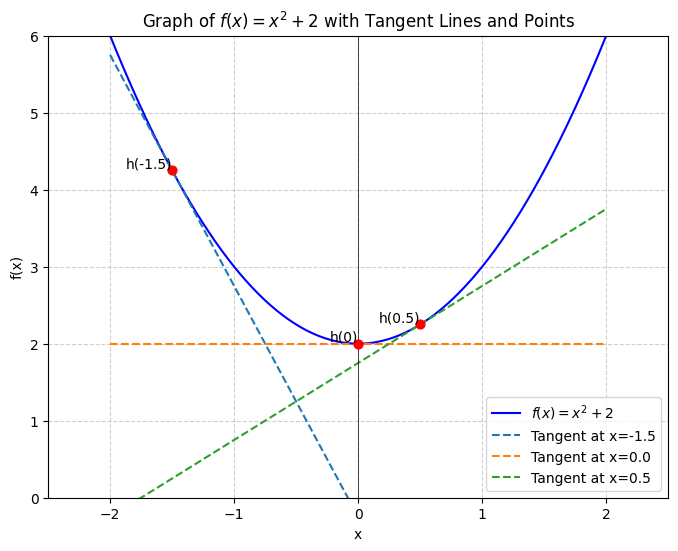

In [5]:
from intuition_vis import vis1
vis1()

Let $x_{min} = 0$, observe that as the value of $x^*$ approaches $x=x_{min}$, the slope of the tangent line $f'(x)$ also approaches $0$ and that when $x^* < x_{min}$, $f'(x) < 0$, and $x^* > x_{min}$, $f'(x) > 0$. Now, let's consider a new function $f(x) = 2x^4 - 3x^3 + 5x^2 - 7x + 4$ (which only has a global minimum), we do not know the value $x_{min}$ that would give the minimum value of $f(x)$, however, we can use the relationship earlier to our advantage to find or approximate $x_{min}$. What we could do is use an initial guess $x_0$ and calculate $f'(x)$, if $f'(x) < 0$, then it means $x^* < x_{min}$, thus we add some small step $\alpha$ to $x_0$ or if $f'(x) > 0$, then it means $x^* > x_{min}$, thus we deduct some small step $\alpha$ to $x_0$ and calculate $f'(x_0 + \alpha)$ or $f'(x_0 - \alpha)$ and repeat until $f'(x_{guess}) \approx 0$. If we reach a point where $x_{guess} - \alpha < x_{min} < x_{guess} + \alpha$, that is $f'(x_0 - \alpha) < 0 < f'(x_0 + \alpha)$, we can use smaller increments say $\beta = \dfrac{\alpha}{2}$ and use that instead.

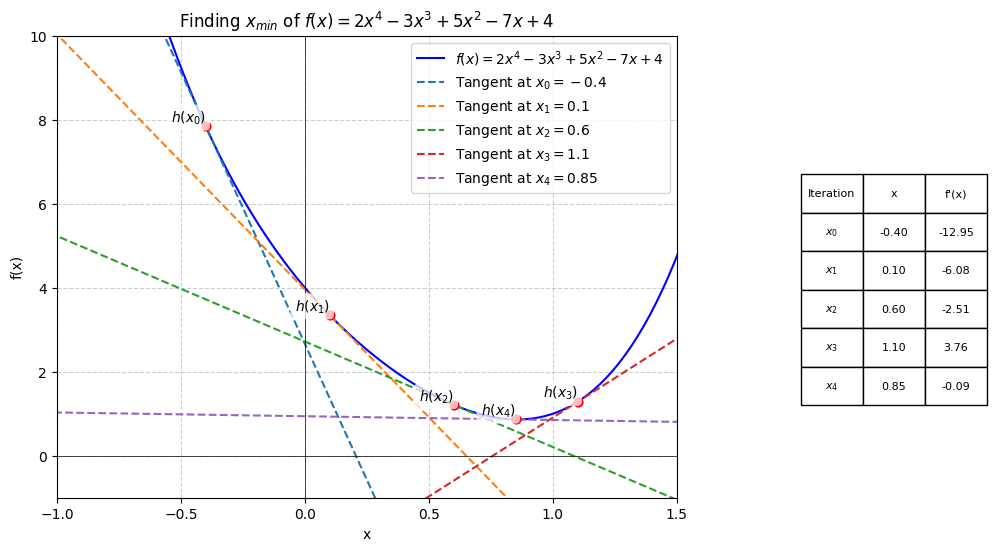

In [6]:
from intuition_vis import vis2
vis2()

Here we tried estimating $x_{min}$ by using the iterative method we mentioned above. We started at $x_0 = -0.4$ and use the increments $\alpha = 0.5$, which makes our update rule $x_{n+1} = x_{n} + \alpha$ if $f'(x_n) < 0$ and $x_{n+1} = x_{n} - \alpha$ if $f'(x_n) > 0$. In our case, this became the update rule until $x_3$, since it is clear that $f'(x_2) < 0 < f'(x_3)$ which means that $x_2 < x_{min} < x_3$. Hence we let $\beta = \dfrac{\alpha}{2}$ and use that increment instead, which gave us $x_4 = 0.85$ and $f'(x_4) = - 0.09$. We can repeatedly make the increments smaller until we get $f'(x_{guess}) \approx 0$ and thus can conclude that $x_{guess} \approx x_{min}$. Note that if we instead wanted to calculate for the maximum (if it exists, we would flip the < into > (and vice versa) and use same update rule). 

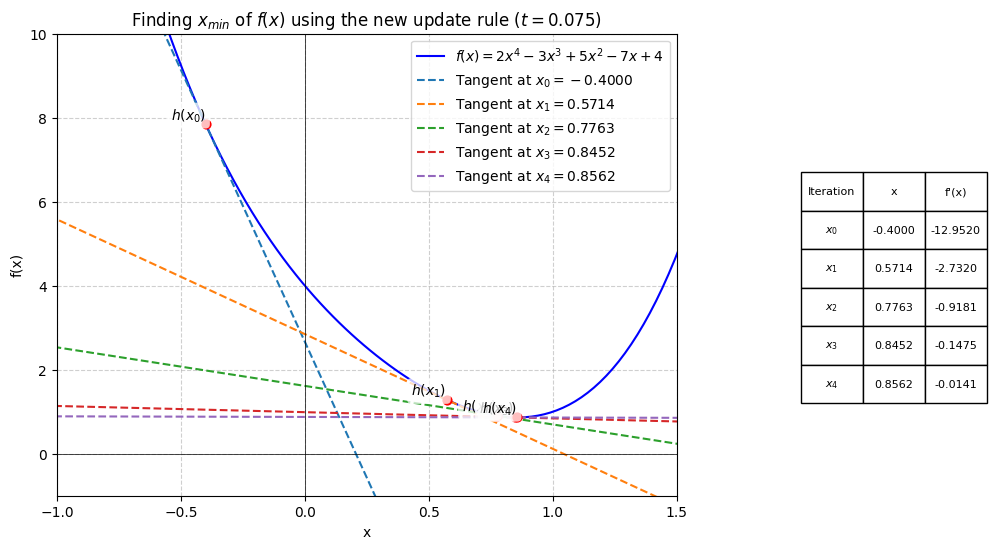

In [7]:
from intuition_vis import vis3
vis3()

This is the main idea behind gradient descent, if we wanted to minimize some function $f(x)$, we utilize the value of $f'(x)$ to essentially 'point' us to the right direction. In fact, we can even change our update rule earlier to reflect this, instead of using $\alpha$ we can let $f'(x_n)$ itself point us to the right direction, if let $x_{n+1} = x_{n} - tf'(x_n)$ for some small $t>0$ and we would get similar results as demonstrated above, this method is called gradient descent. [MIT, Lec07] [CMU, Gormley] \
Here, the small $t>0$ is what we call the learning rate, we can think of it as how big of a step we want take towards the right direction for every estimate. However, it is important to note that bigger steps, more often than not, does not yield better results. An analogy for using learning rates that are too large is using a ruler to measure the width of human hair.

We can use gradient descent to find a solution that minimizes some loss functions and by extension the empirical risk. However, in this example, we assumed that $f(x)$ is differentiable. But what if $f(x)$ is not differentiable or that there are 'kinks' in the graph?\
Consider $$f(x) =
\begin{cases} 
2x^4 - 3x^3 + 5x^2 - 7x + 4, & x > 0 \\
-15x + 4, & x \leq 0
\end{cases},$$ notice that it is not differentiable at $x = 0$.

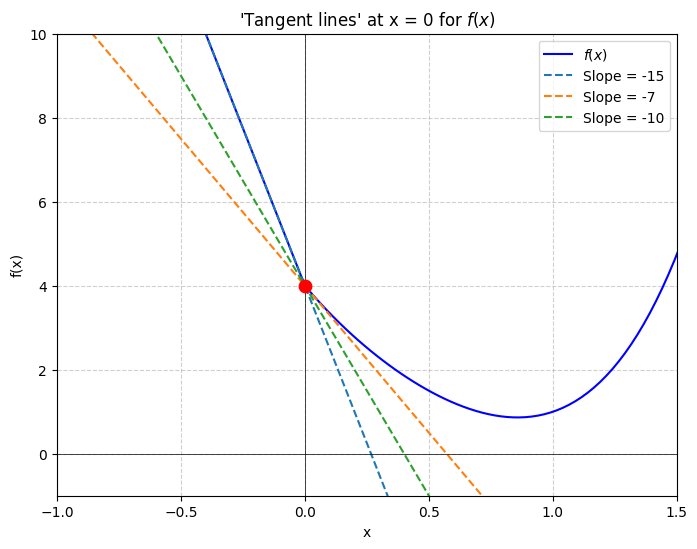

In [8]:
from intuition_vis import vis4
vis4()

However, observe that we can still draw multiple 'tangent lines' at $x = 0$ and if we are going pick our initial guess as $x_0 = 0$ and use the slope values of any one of the tangent lines at $x$, say $m = -10$, as a substitute for $f'(x_0)$ and run the algorithm above to find $x_{min}$, we would find out that we were still able to approximate the solution.

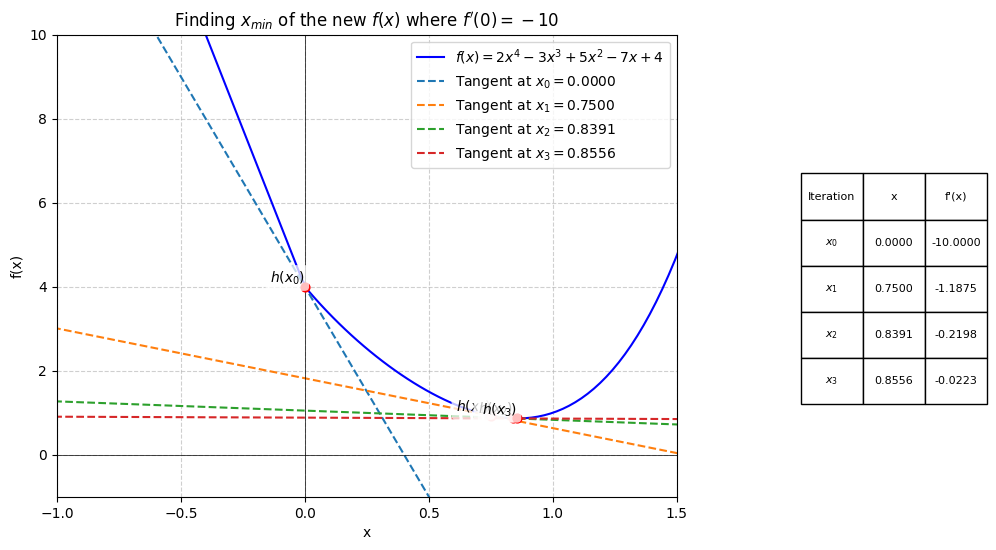

In [9]:
from intuition_vis import vis5
vis5()

In fact, we can define $f'(x) \in [-15, 7]$ whenever $x=0$ and our method would still be able to approximate the solution. Intuitively, $f'(0) \in [-15, 7]$ still points us to the solution even if $f(x)$ is not differentiable at $x$. This method is called subgradient and the multiple tangent lines that we considered above are called subderivatives.

#### (Steepest) Gradient Descent in Parametric Approach

To formalize our notion of the (steepest) gradient descent method, if we have some convex function $f(x)$ where $x = [x_1 \hspace{0.5em} x_2 \hspace{0.5em} \cdots \hspace{0.5em} x_n]^T$ and $f(x)$ has a minimum value evaluated at $x_{min}$. We can approximate $x_{min}$ using gradient descent by defining a sequence of $n$-dimensional vectors (or gradients) $\{r_m\}_1^M$ defined as 
\begin{align*}
r_m &=
\begin{bmatrix}
\dfrac{\partial f(x)}{\partial x_1} \\
\dfrac{\partial f(x)}{\partial x_2} \\
\vdots \\
\dfrac{\partial f(x)}{\partial x_n}
\end{bmatrix}_{x=x^{(m-1)}} \\
&= \nabla f(x^{(m-1)})
\end{align*}
where 
\begin{align*}
x^{(m)} &= \sum_{j=0}^m x_j \\
&= x^{(0)} - h\sum_{i=1}^m r_i
\end{align*} 
where $x^{(0)}$ is some initial guess and $h > 0$ is the learning rate. Here $-\nabla f(x^{(m-1)})$ is the 'steepest' descent, intuitively, it is the most 'correct' direction that we can take a step towards the solution. Our estimate for $x_{min}$ wil be 

\begin{align*}
x_{min} &\approx x^{(M)}
\end{align*}
[gradientdescent1.pdf]

##### Subgradients (CMU STAT 06-Gradients)

However, if $f(x)$ is not differentiable at some $x^{(m)}$, that is $\nabla f(x^{(m)})$ does not exist, we can instead use it's subgradient $h(x^{(m)})$ which satisfies the following $$h(y) - h(x^{(m)}) \geq g^T (y - x^{(m)}) \text{ for all }y$$ for any $g^T \in R^n$. We can then substitute $\nabla f(x^{(m)})$ with $h(x^{(m)})$ for the next iterate. However,  $-h(x^{(m)})$ might not necessarily be the 'steepest' descent or the 'correct' direction at this iterate thus careful monitoring during the iterate is needed when using subgradient and if possible pick $h(x^{(m)})$ that generally points us to the right solution. [Tibshirani] [lecture10-subgrad]

Numerically, we can follow the algorithm below

Algorithm 1 Gradient Descent \
1: Choose initial guess $x_0 ∈ R_n$ \
2: for $m = 1, 2, \dots , M$ do \
3:  Compute the gradient $r_m = \nabla f(x_{m-1}) \in R_n$ \
4:  Update the point: $x_{m} = x_{m-1} − r_m$ \
5: Stop when $||\nabla f(x_m)||_2 < \epsilon$ for some small $\epsilon > 0$

[Gormley][yung book]


Going back to the parametric approach, if we want to estimate some function $F(x)$ using a training dataset $\{(x_1,y_1),(x_2,y_2),\ldots,(x_n,y_n)\}$, we can choose some parametrized function $F'(x;\phi)$ that may closely represent $F(x)$ and solve for the optimal parameters 
\begin{align*}
\phi^* &= \arg\min_{\phi} L(\phi) \\
&= \arg\min_{\phi} \dfrac{1}{n}\sum_{i=1}^{n} l(y_i,F'(x_i;\phi))
\end{align*} 
where $L(\phi)$ is the empirical risk (which would be a function of the parameters $\phi$) and $l(y_i,F'(x_i;\phi))$ is the defined loss function. If $L(\phi)$ is convex with respect to the parameters $\phi$, we can solve for the parameters $\phi^*$ using gradient descent. 

#### Gradient Boosting

To better understand gradient boosting, let's take a look back at how we can minimize $f(x) = 2x^4 - 3x^3 + 5x^2 - 7x + 4$ using gradient descent. We can approximate the parameters at which it is minimum by $$x_{min} = x^{(0)} - h \sum_{i=1}^M \nabla f(x^{(i-1)})$$ where $x^{(0)}$ is some initial guess and $M \in N$ is the total number of iterates. Intuitively, given our initial guess $x^{(0)}$, we can think of $h\nabla f(x^{(i-1)})$ as the correctional steps of our estimate towards the solution and that for every step $x^{(i)}$ we correct it with $h\nabla f(x^{(i-1)})$. To reframe it, we can think of every iterate we do as correcting our previous estimate's error.

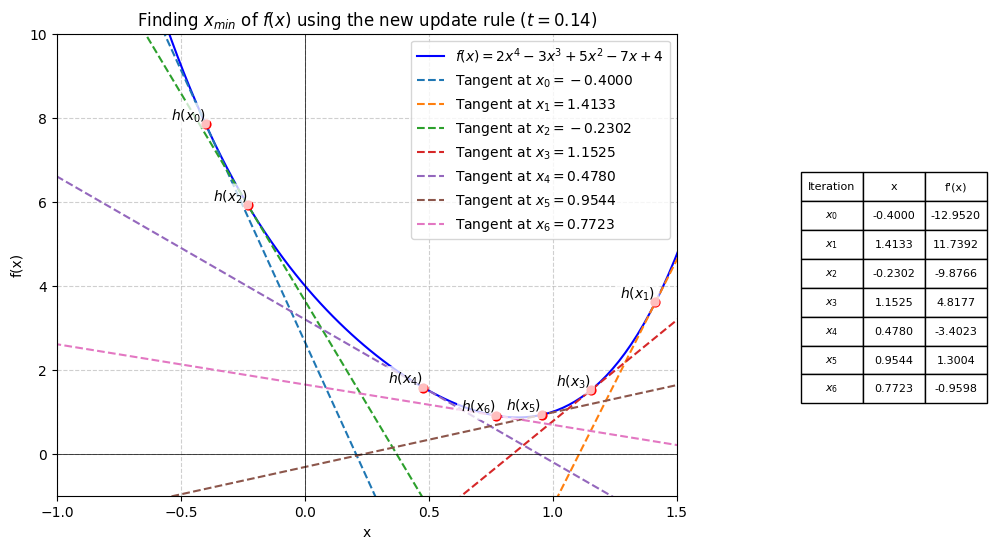

In [10]:
from intuition_vis import vis6
vis6()

To illustrate how each step in the gradient descent process corrects the error the previous iterate has, we deliberately set a larger learning rate $( t = 0.14 )$, making the updates more exaggerated.  

In the image, we see that each estimate $x_i$ alternates around the true solution $x_{min}$. This happens because the correction step, $t \nabla f(x^{(i-1)})$, overshoots the optimal point, causing the estimate to swing back and forth.
However, despite these oscillations, the algorithm still makes progress towards the minimum. Over multiple iterations, the errors are gradually corrected, and the estimate converges to the true solution $x_{min}$. Translating this to the context of minimizing loss functions, this means that every step attempts to reduce the loss function to get to its minimum.

Now, the main idea behind gradient boosting revolves around this notion. In this method, we create a sequence of weak learners that tries to correct the error left by the one before it, thus lower the loss at every correction, and use the weighted sum of all the trees as our final model. The key difference between gradient descent and gradient boosting in estimating some unknown function $F(x)$, given some dataset $\{(x_1,y_1),(x_2,y_2),\ldots,(x_n,y_n)\}$, is that the former assumes the general form of the unkown function $F'(x,\phi)$ and tries to find the best parameters $\phi^*$ that minimizes some loss function $L(\phi)$, while the latter instead tries to create $F^*(x)$ that best represents $F(x)$ based on the available data. In this research, the weak learner we will be using are regression trees.

|    | Gradient Descent  | Gradient Boosting  |
|-----------|-----------|-----------|
| Problem Formulation  | $\displaystyle \phi^* = \arg\min_{\phi} L(\phi)$    | $\displaystyle F^*(x) = \arg\min_{F'(x)} L(F'(x))$    |
| Descent Direction at Step $m$ | $- \nabla L(\phi^{(m-1)})$ | $\displaystyle h^{(m-1)}(x) = \arg\min_{h(x)} \sum_{i=1}^n[- \nabla L(F^{(m-1)}(x_i))- h(x_i)]^2$ |  
| Correction Step | $\phi^{(m)} = \phi^{(m-1)} - h \nabla L(\phi^{(m-1)})$ | $\displaystyle F^{(m)} = F^{(m-1)}(x) - \lambda h^{(m-1)}(x)$ |
| Initial Estimate | Parameter $\phi^{(0)}$ | Weak learner $h^{(0)}$ |
| $F(x)$ Estimate | $F(x;\phi^*)$ where $\displaystyle \phi^* = \phi^{(0)} + h\sum_{m=1}^M \phi^{(m)}$ | $\displaystyle F^*(x) = h^{(0)} + \lambda \sum_{m=1}^M h^{(m)}$|

The table above will be used as a reference to demonstrate how gradient boosting is the non-parametric and data-driven analogue to gradient descent. As mentioned above, the main goal of gradient boosting is to generate $\displaystyle F^*(x) = \arg\min_{F'(x)} L(F'(x))$ such that it closely represents the actual function $F(x)$ given the dataset $\{(x_1,y_1),(x_2,y_2),\ldots,(x_n,y_n)\}$. Much like gradient descent, we start with some initial guess $F^{(0)}(x)$ and slowly 'correct' it, reducing  $L(F^{(m)}(x))$ as the iterate $m$ goes on. However, one key difference between gradient descent and gradient boosting is how they 'correct' each estimates, unlike gradient descent, instead of using the gradient of the empirical risk, we improve the function estimate $F^{(m)}(x)$ by adding another function which is defined as $$h^{(m)}(x) = \arg\min_{h(x)} \sum_{i=1}^n[- \nabla L(F^{(m-1)}(x_i))- h(x_i)]^2,$$ this is because in gradient decsent, given the estimate $\phi^{(m)} = [\phi_1^{(m)} \hspace{0.5em} \phi_2^{(m)} \hspace{0.5em} \cdots \hspace{0.5em} \phi_p^{(m)}]^T$, our descent direction is given by
\begin{align*}
-\nabla L(\phi^{(m)}) &= -
\begin{bmatrix}
\dfrac{\partial L(\phi)}{\partial \phi_1} \\
\dfrac{\partial L(\phi)}{\partial \phi_2} \\
\vdots \\
\dfrac{\partial L(\phi)}{\partial \phi_p}
\end{bmatrix}_{\phi=\phi^{(m)}} \\
&= -
\begin{bmatrix}
\dfrac{\partial L(F(x;\phi))}{\partial \phi_1} \\
\dfrac{\partial L(F(x;\phi))}{\partial \phi_2} \\
\vdots \\
\dfrac{\partial L(F(x;\phi))}{\partial \phi_p}
\end{bmatrix}_{\phi=\phi^{(m)}} \\
\end{align*}
which is defined for every $x$, thus the resulting estimate from this method, say $F(x;\phi^*)$, will also be defined for every $x$. On the other hand, in gradient boosting, given the estimate $F^{(m)}(x)$ at step $m$, our descent direction at point $x_i$ will be given by
\begin{align*}
-\nabla L(F^{(m)}(x_i)) &= -
\begin{bmatrix}
\dfrac{\partial L(F(x_i))}{\partial F(x_i)} 
\end{bmatrix}_{F(x)=F^{(m)}(x)}. \\
\end{align*}
This, however, will only be defined for the data point $x_i$ and most likely have different values for $x_j$ whenever $j \neq i$, making our final estimate $F^*(x)$ only defined on our training data inputs $x_1, x_2, \ldots , x_n$. Thus, we want to generalize $L(F^{(m)}(x))$ for all values $x$. In a boosting approach, we typically just fit another weak learner $h^{(m)}(x)$ on $L(F^{(m)}(x))$ (also called pseudoresiduals), or in other words solve for $$h^{(m)}(x) = \arg\min_{h(x)} \sum_{i=1}^n[- \nabla L(F^{(m-1)}(x_i))- h(x_i)]^2$$ we typically use regression to find such $h^{(m)}(x)$. To clear up possible confusions in the future, it is important to note that the loss function (and by extension, the empirical risk) that we use to evaluate the fit of our estimate $F^{(m)}(x)$ on the target variable data is not necessarily the same loss function used for evaluating the fit of $h^{(m)}(x)$ on the pseudoresiduals. For better distinction, given some dataset $\{(x_1,y_1),(x_2,y_2),\ldots,(x_n,y_n)\}$, we will denote the empirical risk to evaluate the fit of $h(x)$ on the pseudoresiduals as $$R \left( g(x), h(x) \right) = \sum_{i=1}^{n} l_R(g(x_i), h(x_i))$$ where $g(x_i) = \dfrac{\partial L(F(x_i))}{\partial F(x_i)}$ is the pseudoresidual, and $l_R(g(x_i), h(x_i))$ is the loss function, typically the RSS, to evaluate the fit of $h(x_i)$ on the pseudoresidual evaluated at $x_i$ which is not necessarily the same used for $L(F(x_i))$. We then use this $h^{(m)}(x)$ to improve the errors of our estimate $F^{(m)}(x)$ giving us the new estimate $F^{(m+1)}(x) = F^{(m)}(x) + h^{(m)}(x)$. This process would then yield the final estimate $$ F^*(x) = h^{(0)} + \lambda \sum_{m=1}^M h^{(m)}.$$ The code below implements the gradient boosting algorithm mentioned in this section using regression trees, which was discussed previously, as a weak learner. 

In [11]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from loss_functions import *
# from regression_tree import *

class GradientBoost:
    def __init__(self, loss_function: LossFunction, n_estimators: int = 100,
                 learning_rate: float = 0.01, max_depth: int = 1, min_points: int = 20):
        self.loss_function = loss_function
        self.ensemble = []
        self.loss = []
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_points = min_points
        self.init_tree = None
        self.init_guess = None
        self.init_guess_mean = None
        self.last_guess = None
    
    def predict(self, X: pd.DataFrame, training: bool = False):
        predictions = np.zeros(X.shape[0])
        if training:
            predictions = self.last_guess
            predictions += self.learning_rate * self.ensemble[-1].evaluate(X)
            self.last_guess = predictions
        else:
            predictions = self.init_tree.evaluate(X) if self.init_tree is not None else np.full(X.shape[0], self.init_guess_mean)
            for tree in self.ensemble[1:]:
                predictions += self.learning_rate * tree.evaluate(X)
        # for tree in self.ensemble[1:]:
        #     predictions += self.learning_rate * tree.evaluate(X)
        return pd.Series(predictions, index=X.index)

    def fit(self, X: pd.DataFrame, y: pd.Series, init_tree: Tree = None, early_stopping: int = 5):
        self.init_tree = init_tree
        self.init_guess_mean = y.mean()
        self.init_guess = pd.Series(init_tree.evaluate(X), index=y.index) if init_tree is not None else pd.Series(np.full(y.shape, y.mean()), index=y.index)
        self.last_guess = self.init_guess.copy()
        if init_tree is not None:
            self.ensemble.append(init_tree)
        pseudo_residuals = pd.Series(-self.loss_function.gradient(y, self.init_guess), index=y.index)
        loss = self.loss_function.loss(y, self.init_guess)
        loss_increase = 0
        self.loss.append(loss)
        print(f"Iteration: 0, Loss: {loss:.4f}")
        for i in range(self.n_estimators):
            tree = Tree(X=X, y=pseudo_residuals)
            tree.generate_tree(max_depth=self.max_depth, min_points=self.min_points)
            self.ensemble.append(tree)
            predictions = self.predict(X, training=True)
            pseudo_residuals = pd.Series(-self.loss_function.gradient(y, predictions), index=y.index)
            loss = self.loss_function.loss(y, predictions)
            if loss >= self.loss[-1]:
                loss_increase += 1
            self.loss.append(loss)
            print(f"Iteration: {i + 1}, Loss: {loss:.4f}")
            if loss_increase >= early_stopping:
                print(f"Early stopping at iteration {i}")
                break
        return self
    
    def plot_loss(self):
        plt.plot(self.loss)
        plt.title("Loss vs. Iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.show()

In [12]:
import pandas as pd
import numpy as np
from regression_tree import Node, Tree
# Set random seed for reproducibility
np.random.seed(42)

# Generate 3 features
N = 3000  # Number of samples
X1 = np.random.uniform(-10, 15, N)  # Uniformly distributed between -2 and 2
X2 = np.random.uniform(0, np.pi, N)  # Between 0 and π for sin function
X3 = np.random.normal(5, 2, N)  # Normally distributed around 5 with std 2

# Define target variable with nonlinear function and noise
noise = np.random.normal(0, 50, N)
y = 3 * X1**2 + 2 * np.sin(X2) + 0.5 * X3 + noise

# Create a DataFrame
df = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'y': y})
X = df[['X1', 'X2', 'X3']]
y = df['y']

##### Fitting the model

In [13]:
gb = GradientBoost(loss_function=SSR(),n_estimators=100, learning_rate=0.5, max_depth=1, min_points=20)
gb.fit(X=X, y=y)

Iteration: 0, Loss: 99738972.3097
Iteration: 1, Loss: 18372437.9957
Iteration: 2, Loss: 11723332.5151
Iteration: 3, Loss: 11078103.4677
Iteration: 4, Loss: 9845949.7420
Iteration: 5, Loss: 8969572.6409
Iteration: 6, Loss: 8586264.3535
Iteration: 7, Loss: 8220938.9696
Iteration: 8, Loss: 8059427.8331
Iteration: 9, Loss: 7771362.1210
Iteration: 10, Loss: 7738860.8552
Iteration: 11, Loss: 7644322.6285
Iteration: 12, Loss: 7575647.1930
Iteration: 13, Loss: 7565628.5939
Iteration: 14, Loss: 7556038.1729
Iteration: 15, Loss: 7502863.9171
Iteration: 16, Loss: 7461187.9706
Iteration: 17, Loss: 7301198.5255
Iteration: 18, Loss: 7132164.4194
Iteration: 19, Loss: 7024757.4843
Iteration: 20, Loss: 6955555.9944
Iteration: 21, Loss: 6880995.4355
Iteration: 22, Loss: 6844870.8695
Iteration: 23, Loss: 6838095.5761
Iteration: 24, Loss: 6831906.5682
Iteration: 25, Loss: 6823492.1608
Iteration: 26, Loss: 6795513.3307
Iteration: 27, Loss: 6777317.6050
Iteration: 28, Loss: 6765807.9568
Iteration: 29, Loss:

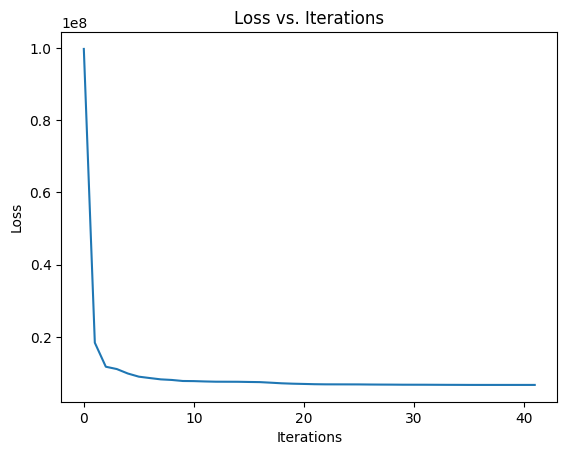

In [14]:
gb.plot_loss()

##### Testing the model

In [15]:
# Generate 3 features
N = 20  # Number of samples
X1 = np.random.uniform(-10, 15, N)  # Uniformly distributed between -2 and 2
X2 = np.random.uniform(0, np.pi, N)  # Between 0 and π for sin function
X3 = np.random.normal(5, 2, N)  # Normally distributed around 5 with std 2
# Define target variable with nonlinear function and noise
noise = np.random.normal(0, 50, N)
y = 3 * X1**2 + 2 * np.sin(X2) + 0.5 * X3 + noise
df = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'y': y})
X = df[['X1', 'X2', 'X3']]
y = df['y']

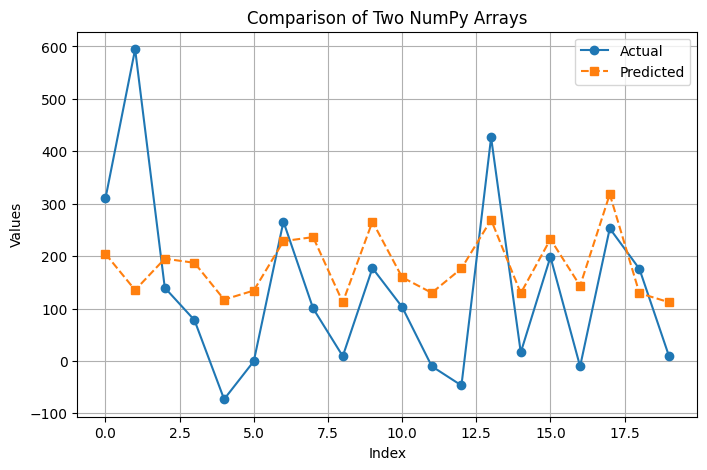

In [16]:
import numpy as np
import matplotlib.pyplot as plt

predicted = gb.predict(X)
# Plot
plt.figure(figsize=(8, 5))
plt.plot(y.index, y, label="Actual", marker="o", linestyle="-")
plt.plot(predicted.index, predicted, label="Predicted", marker="s", linestyle="--")

# Labels and legend
plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Comparison of Two NumPy Arrays")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

#### Extreme Gradient Boosting (XGBoost)

##### Regularization

The main objective of regression and ultimately trying to estimate some function $F(X)$ given the data $\{(x_1,y_1),(x_2,y_2),\ldots,(x_n,y_n)\}$, is to identify the relationship between the predictors $X = [X_1 \hspace{0.5em} X_2 \hspace{0.5em} \cdots \hspace{0.5em} X_n]^T$ and the target variable $y$, or in other words uncover $F(x)$ such that $y=F(X)$. In the ideal setting where all predictors $X_1, X_2, \ldots, X_n$ does indeed have a relationship with the target variable $y$, methods like gradient boosting will be able to estimate such relationship with relatively high accuracy. However, in a real world dataset, not every features or predictors might contribute to the target variable and using them to train a model would hinder the prediction accuracy most of the time and make the model more complex than it needs to be, impeding model interpretability. Relying too much on the training data and all the predictors present is also called *overfitting* [IBM](https://www.ibm.com/think/topics/overfitting), and it is detrimental to the predicting power and the performance of the model on unseen data \
We demonstrate this below.

In [17]:
import pandas as pd
import numpy as np
from regression_tree import Node, Tree
# Set random seed for reproducibility
np.random.seed(42)

# Generate 3 features
N = 3000  # Number of samples
X1 = np.random.uniform(-10, 15, N)  
X2 = np.random.uniform(0, np.pi, N)  
X3 = np.random.normal(5, 2, N)  
X4 = np.random.normal(9, 3, N) + np.random.uniform(3, 2, N) # Create a dummy predictor that does not contribute to y

# Define target variable with nonlinear function and noise
noise = np.random.normal(0, 50, N)
y = 3 * X1**2 + 2 * np.sin(X2) + 0.5 * X3 + noise

# Create a DataFrame
df = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'X4': X4, 'y': y})
X = df[['X1', 'X2', 'X3', 'X4']]
y = df['y']

In [18]:
gb_test = GradientBoost(loss_function=SSR(),n_estimators=100, learning_rate=0.5, max_depth=1, min_points=20)
gb_test.fit(X=X, y=y)

Iteration: 0, Loss: 101532178.6297
Iteration: 1, Loss: 21021624.8645
Iteration: 2, Loss: 12613889.2233
Iteration: 3, Loss: 11916589.3969
Iteration: 4, Loss: 10255864.1175
Iteration: 5, Loss: 9562548.9132
Iteration: 6, Loss: 8732669.2075
Iteration: 7, Loss: 8464774.9505
Iteration: 8, Loss: 8189994.0914
Iteration: 9, Loss: 8126347.4944
Iteration: 10, Loss: 8069239.8145
Iteration: 11, Loss: 8052332.4626
Iteration: 12, Loss: 8052332.4626
Iteration: 13, Loss: 8052332.4626
Iteration: 14, Loss: 8052332.4626
Iteration: 15, Loss: 8052332.4626
Iteration: 16, Loss: 8052332.4626
Early stopping at iteration 15


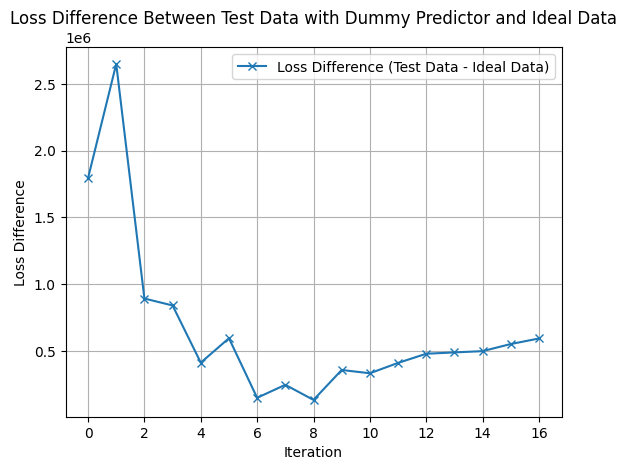

In [19]:
import matplotlib.pyplot as plt
import numpy as np

min_range = min(len(gb.loss), len(gb_test.loss))

gb_loss = np.array(gb.loss)
gb_test_loss = np.array(gb_test.loss)

loss_difference = gb_test_loss[:min_range] - gb_loss[:min_range]

plt.plot(range(min_range), loss_difference, marker='x', label='Loss Difference (Test Data - Ideal Data)')

plt.xlabel('Iteration')
plt.ylabel('Loss Difference')  
plt.legend()
plt.title('Loss Difference Between Test Data with Dummy Predictor and Ideal Data')
plt.grid(True) 
plt.show()

As you can see from the loss vs. iteration comparison above, whenever a dataset has features that does nothing for the target variable, it reduces the accuracy of the model and hinders the overall performance [springer]. \
Reguralization (also known as shrinkage), is an approach used to mitigate the problem stated previously by assigning weights $\beta_i$ to the predictor variables and tries to find the most optimal weights that minimizes the loss. This usually involves trying to find the smallest possible $\beta_i$ for each $X_i$ (hence, shrinkage). The objective of regularization is to minimize the following $$\hat{L}(\beta) = L(y, f(X, \beta)) + \epsilon \Omega(\beta)$$ where $\beta = [\beta_1 \hspace{0.5em} \beta_2 \hspace{0.5em} \cdots \hspace{0.5em} \beta_n]^T$ are the weights for the predictors $X$, $L(y, f(X, \beta))$ is the empirical risk, $\Omega (\beta)$ is the regularization penalty, and $\epsilon >= 0$ is the tuning parameter that dictates how much we want to penalize the magnitude of the weights. \
**Ridge Regression** (feifei lecture_3) \
One regularization method that can be used is called ridge regression (also known as L2 Regularization). For this method, the regularization penalty is defined as 
\begin{align*}
\Omega _{L2}(\beta) &= \|\beta\|^2_2 \\
&= \sum_{i=1}^n \beta_i^2.
\end{align*}
This penalty seeks to find the smallest weight possible for all the predictors that minimizes the empirical risk, which is designed to reduce the weight of predictors that do not contribute to the target variable. \
**Lasso** \
However, one disadvantage of L2 regularization is that although it's penalty sets the weights as close as possible to zero, it would not be able to set any of it to zero (unless $\epsilon = \infty$). Thus, lasso (also known as L1 Regularization) overcomes this advantage of L2 Regularization by using the following skrinkage penalty 
\begin{align*}
\Omega _{L1}(\beta) &= \|\beta\|_2 \\
&= \sum_{i=1}^n |\beta_i|.
\end{align*}
This penalty shrinks weights to zero given large enough $\epsilon$, eliminating the contribution of possibly unrelated predictors. L1 regularization essentially performs variable selection from the available predictors. \
**Pruning** (pruning_regu) \
Another method that can be used to help regularize the model is limiting the complexity of it for better generalization. In the context of trees, even if we achieve a good decision tree for the training data, it may not yield the same results for the test data or any predictions made after. This is due to the possibility of overfitting the model to the training data and irrelevant information and making it too complex to yield a small RSS. Thus, making the regression tree less complex or smaller might yield better results for the test data and predictions, lowering the variance and improving the interpretability in exchange for higher bias. [springer] \
*Cost Complexity Pruning* is one approach that simplifies the model by penalizing complexity to *'prune'* or remove leaves to make the tree smaller and less complex. We can define this penalty with the tuning parameter $\alpha>0$ as $$\Omega_C(T) = \alpha |T|$$ where $|T|$ is the number of terminal nodes or leaves of the tree $T$. This penalty balances the trade-off between the complexity of the model and its fit to the training data, mitigating overfitting.

##### Intuition Behind Regularization in View of Gradient Boosting
Since we are taking the gradients of the loss function with respect to the predictors and using them as correction steps, if there are some predictors that does not contribute to the target value, those gradients might not be as good of a correction as we think it is. In the basic gradient boosting method we discussed earlier, we treat every correction step equally, that is we just keep adding them to the ensemble scaled with a constant learning rate. Regularization mitigates this by essentially introducing doubt on every step making us do the smallest step that we can take that still pushes us to the correct direction; the bigger the step, the bigger the doubt (hence, a larger penalty). What regularization does in the context of gradient boosting (using regression trees) is to reduce the contribution of the tree's output to the whole ensemble (the tree that was fitted on the pseudoresiduals) as much as possible while also reducing the mistake made from the previous estimate (pseudoresiduals). This gives us a balance between trying to correct the previous mistake and not overly relying on pseudoresiduals.

##### Regularization for Trees
With this in mind, we would now introduce how to apply regularization for trees. Recall that when we evaluate a regression tree, we usually get the mean response of the terminal node of where the input belongs to, which as we discussed earlier, might not be the best output. In regularization, our goal now is to build a tree that best represents the pseudoresiduals while minimizing the output values and model complexity as much as possible. In other words, given a dataset $\{(x_1,y_1),(x_2,y_2),\ldots,(x_n,y_n)\}$, and the previous estimate $F^{(m-1)}(X)$, the objective will be to build a tree $h^{(m)}(X)$ to correct it at step $m$ such that it minimizes 
\begin{align*}
R(h^{(m)}(x_i)) &= L(y,F^{(m-1)}(x) + h^{(m)}(x)) + \Omega_C(T) + \dfrac{1}{2}\Omega_{L2}(h^{(m)}(x)) \\
&= \dfrac{1}{n}\sum_{i = 1}^n l(y_i,F^{(m-1)}(x_i) + h^{(m)}(x_i)) + \alpha |T| + \dfrac{1}{2}\sum_{i = 1}^n h^{(m)}(x_i)^2
\end{align*}
where $l$ is our defined loss funtion, $\alpha$ is the cost complexity parameter, and $|T|$ is the number of terminal nodes the tree has (the $\dfrac{1}{2}$ term is just there to simplify our future calculations). We can work towards minimizing this espression more easily by breaking down the minimization on the node level and taking the greedy approach. In addition, the tree $h^{(m)}(x_i)$ is not even differentiable and that $T$ cannot be determined until the final tree was build, thus the node level minimization will be the most viable approach. Recall that in creating a regression tree, we split the values of the target variables $y$ by some criterion based on the predictors $x$, which means that every terminal node would contain $y$ that belongs to it (i.e. it's predictors checks all the criteria), and we assign an output value on to that terminal node which we defined on a regression tree as the mean of $y$'s contained in that terminal node. Note that the output of $h(x)$ would depend on the terminal node the predictors classified in, thus if we want to minimize $h(x)$ for regularization, we need to minimize the individual outputs of it's terminal nodes. This would make the process less difficult since we can just focus on one variable, the output value on the terminal node. Now, let $t$ be the terminal node, $\{(x_1,y_1),(x_2,y_2),\ldots,(x_n,y_n)\}$ be the dataset where $x_i$ are the predictors, that is $x_i=[x_{i1} \hspace{0.5em} x_{i2} \hspace{0.5em} \cdots \hspace{0.5em} x_{im}]$ of the target variable $y_i$, and $R_t(j,s) = \{X| X_{j} < s \}$ (or $\{X| X_{j} \ge s \}$) contain all the qualified predictors $x_i$ of $y_i$'s based on some split on the predictor $x_{ij}$ by $s$. We want to find the output value $O_t$ for the terminal node $t$ such that it minimizes $$\sum_{i:x_i \in R_t(j,s)} \left[l(y_i,F^{(m-1)}(x_i) + O_t)\right] + \dfrac{1}{2} \epsilon O_t^2.$$ From here, we can approximate $l(y_i,F^{(m-1)}(x_i) + O_t)$ using the second order taylor expansion, that is
\begin{align*}
\sum_{i:x_i \in R_t(j,s)} l(y_i,F^{(m-1)}(x_i) + O_t) &\approx \sum_{i:x_i \in R_t(j,s)} \left[ l(y_i,F^{(m-1)}(x_i)) + \dfrac{d l(y_i,F^{(m-1)}(x_i))}{d F^{(m-1)}(x_i)} O_t + \dfrac{1}{2} \dfrac{d^2 l(y_i,F^{(m-1)}(x_i))}{d F^{(m-1)}(x_i)^2} O_t^2 \right] + \dfrac{1}{2} \epsilon O_t^2 \\
&= \sum_{i:x_i \in R_t(j,s)} l(y_i,F^{(m-1)}(x_i)) + \sum_{i:x_i \in R_t(j,s)} \dfrac{d l(y_i,F^{(m-1)}(x_i))}{d F^{(m-1)}(x_i)} O_t +  \left( \sum_{i:x_i \in R_t(j,s)} \dfrac{d^2 l(y_i,F^{(m-1)}(x_i))}{d F^{(m-1)}(x_i)^2} + \epsilon\right) \dfrac{1}{2} O_t^2.
\end{align*}
Notice that this expression above is just a quadratic equation with respect to $O_t$, and recall that in the beginning, we would assume that all the loss functions $l$ that we will use is convex, which means that $\dfrac{d^2 l(y_i,F^{(m-1)}(x_i))}{d F^{(m-1)}(x_i)^2}$ (also known as the hessian) will be positive for all $i:x_i \in R_t(j,s)$, thus $O_t^2$ has a positive coeffecient. Hence the second order taylor expansion of $\sum_{i:x_i \in R_t(j,s)} l(y_i,F^{(m-1)}(x_i) + O_t)$ will be a quadratic function that will have a global minimum with respect to $O_t$. From that, we can get the minimum of the expression above using the first derivative of it with respect to $O_t$ which would give us $$\dfrac{d \left[ \sum_{i:x_i \in R_t(j,s)} l(y_i,F^{(m-1)}(x_i) + O_t) \right]}{d O_t} \approx \sum_{i:x_i \in R_t(j,s)} \dfrac{d l(y_i,F^{(m-1)}(x_i))}{d F^{(m-1)}(x_i)} +  \left( \sum_{i:x_i \in R_t(j,s)} \dfrac{d^2 l(y_i,F^{(m-1)}(x_i))}{d F^{(m-1)}(x_i)^2} + \epsilon\right) O_t,$$ equating it to zero will allow us to get the optimal value of $O_t$, that is $$\sum_{i:x_i \in R_t(j,s)} \dfrac{d l(y_i,F^{(m-1)}(x_i))}{d F^{(m-1)}(x_i)} +  \left( \sum_{i:x_i \in R_t(j,s)} \dfrac{d^2 l(y_i,F^{(m-1)}(x_i))}{d F^{(m-1)}(x_i)^2} + \epsilon\right) O_t = 0$$ which would give us $$O_t = \dfrac{-\sum_{i:x_i \in R_t(j,s)} \dfrac{\displaystyle d l(y_i,F^{(m-1)}(x_i))}{\displaystyle d F^{(m-1)}(x_i)}}{\sum_{i:x_i \in R_t(j,s)} \dfrac{d^2 l(y_i,F^{(m-1)}(x_i))}{d F^{(m-1)}(x_i)^2} + \epsilon}.$$ 



##### Decision Tree for XGBoost
In gradient boosting we build trees to fit the pseudoresiduals of the previous estimates using regression and add it to the enseble to reduce the pseudoresidual that way. On the other hand, in XGBoost we will generate the next tree that will directly reduce the empirical risk and regularization penalty of the model from the training data as a whole. This means that instead of splitting the nodes that achieves the least RSS of the (regression) tree with respect to the pseudoresidual, we would split the nodes that would achieve the least empirical risk of the model and the regularization penalty with respect to the training data contained on that node. That is, let $P$ denote the parent node and $CL, CR$ be the child nodes of $P$ where $$R_P(j^*,s^*)$$ contains all the training data from some previous split $s^*$ based on the predictor $j*$ (or just $\{x_i|\text{ for all } i=1,\ldots,n\}$ if it is the root node), $$R_{CL}(j,s) = \{X \in R_P(j^*,s^*) | X_j < s\},$$ and $$R_{CR}(j,s) = \{X \in R_P(j^*,s^*) | X_j \ge s\}.$$ Let the dataset $\{(x_1,y_1),(x_2,y_2),\ldots,(x_n,y_n)\}$ have $m$ predictors, that is $x_i=[x_{i1} \hspace{0.5em} x_{i2} \hspace{0.5em} \cdots \hspace{0.5em} x_{im}]$ for the target variable $y_i$, $l$ be a convex loss function that we chose to evaluate the model on the dataset, $P$ be a parent node, $CL, CR$ be the child nodes of $P$, and some $\epsilon$ be the tuning parameter for regularization. We want to find the best split $s$ and the predictor $j$ to split it on, such that $$S(j,s) = \sum_{h:x_h \in R_{CL}(j,s)} l(y_h,F^{(m-1)}(x_h) + O_{CL}) + \dfrac{1}{2} \epsilon O_{CL}^2 + \sum_{i:x_i \in R_{CR}(j,s)} l(y_i,F^{(m-1)}(x_i) + O_{CR}) + \dfrac{1}{2} \epsilon O_{CR}^2$$ is minimum for the $m$-th tree. Using the second order taylor expansion, we will have $$\sum_{h:x_h \in R_{CL}(j,s)} l(y_h,F^{(m-1)}(x_h) + O_{CL}) \approx \sum_{h:x_h \in R_{CL}(j,s)} \left[ l(y_h,F^{(m-1)}(x_h)) + \dfrac{d l(y_h,F^{(m-1)}(x_h))}{d F^{(m-1)}(x_h)} O_{CL} + \dfrac{1}{2} \dfrac{d^2 l(y_h,F^{(m-1)}(x_h))}{d F^{(m-1)}(x_h)^2} O_{CL}^2 \right]$$ and $$\sum_{i:x_i \in R_{CR}(j,s)} l(y_h,F^{(m-1)}(x_h) + O_{CL}) \approx \sum_{i:x_i \in R_{CR}(j,s)} \left[ l(y_i,F^{(m-1)}(x_i)) + \dfrac{d l(y_i,F^{(m-1)}(x_i))}{d F^{(m-1)}(x_i)} O_{CR} + \dfrac{1}{2} \dfrac{d^2 l(y_i,F^{(m-1)}(x_i))}{d F^{(m-1)}(x_i)^2} O_{CR}^2 \right].$$ Which would give us 
\begin{align*}
S(j,s) \approx &\sum_{h:x_h \in R_{CL}(j,s)} \left[ l(y_h,F^{(m-1)}(x_h)) + \dfrac{d l(y_h,F^{(m-1)}(x_h))}{d F^{(m-1)}(x_h)} O_{CL} + \dfrac{1}{2} \dfrac{d^2 l(y_h,F^{(m-1)}(x_h))}{d F^{(m-1)}(x_h)^2} O_{CL}^2 \right] + \dfrac{1}{2} \epsilon O_{CL}^2\\
&+ \sum_{i:x_i \in R_{CR}(j,s)} \left[ l(y_i,F^{(m-1)}(x_i)) + \dfrac{d l(y_i,F^{(m-1)}(x_i))}{d F^{(m-1)}(x_i)} O_{CR} + \dfrac{1}{2} \dfrac{d^2 l(y_i,F^{(m-1)}(x_i))}{d F^{(m-1)}(x_i)^2} O_{CR}^2 \right] + \dfrac{1}{2} \epsilon O_{CR}^2\\
= & \sum_{h:x_h \in R_{CL}(j,s)} \left[ l(y_h,F^{(m-1)}(x_h)) \right] + \sum_{h:x_h \in R_{CL}(j,s)} \left[\dfrac{d l(y_h,F^{(m-1)}(x_h))}{d F^{(m-1)}(x_h)} O_{CL} + \dfrac{1}{2} \dfrac{d^2 l(y_h,F^{(m-1)}(x_h))}{d F^{(m-1)}(x_h)^2} O_{CL}^2 \right] + \dfrac{1}{2} \epsilon O_{CL}^2\\
&+ \sum_{i:x_i \in R_{CR}(j,s)} \left[ l(y_i,F^{(m-1)}(x_i)) \right] + \sum_{i:x_i \in R_{CR}(j,s)} \left[\dfrac{d l(y_i,F^{(m-1)}(x_i))}{d F^{(m-1)}(x_i)} O_{CR} + \dfrac{1}{2} \dfrac{d^2 l(y_i,F^{(m-1)}(x_i))}{d F^{(m-1)}(x_i)^2} O_{CR}^2 \right] + \dfrac{1}{2} \epsilon O_{CR}^2\\
= & \sum_{g:x_g \in R_{P}(j^*,s^*)} \left[ l(y_g,F^{(m-1)}(x_g)) \right] + \left[\sum_{h:x_h \in R_{CL}(j,s)} \dfrac{d l(y_h,F^{(m-1)}(x_h))}{d F^{(m-1)}(x_h)} \right] O_{CL} + \dfrac{1}{2} \left[ \sum_{h:x_h \in R_{CL}(j,s)}  \dfrac{d^2 l(y_h,F^{(m-1)}(x_h))}{d F^{(m-1)}(x_h)^2} + \epsilon\right] O_{CL}^2  \\
&+ \left[ \sum_{i:x_i \in R_{CR}(j,s)} \dfrac{d l(y_i,F^{(m-1)}(x_i))}{d F^{(m-1)}(x_i)}\right] O_{CR} + \dfrac{1}{2} \left[ \sum_{i:x_i \in R_{CR}(j,s)} \dfrac{d^2 l(y_i,F^{(m-1)}(x_i))}{d F^{(m-1)}(x_i)^2}+ \epsilon\right] O_{CR}^2. \\
\end{align*}
Observe that $\displaystyle \sum_{g:x_g \in R_{P}(j^*,s^*)} \left[ l(y_g,F^{(m-1)}(x_g)) \right]$ will be constant for all $j,s$, thus we can omit it from the expression that we will minimize. Hence, the new expression we will minimize would be 
\begin{align*}
T(j,s) = & \left[\sum_{h:x_h \in R_{CL}(j,s)} \dfrac{d l(y_h,F^{(m-1)}(x_h))}{d F^{(m-1)}(x_h)} \right] O_{CL} + \dfrac{1}{2} \left[ \sum_{h:x_h \in R_{CL}(j,s)}  \dfrac{d^2 l(y_h,F^{(m-1)}(x_h))}{d F^{(m-1)}(x_h)^2} + \epsilon\right] O_{CL}^2  \\
&+ \left[ \sum_{i:x_i \in R_{CR}(j,s)} \dfrac{d l(y_i,F^{(m-1)}(x_i))}{d F^{(m-1)}(x_i)}\right] O_{CR} + \dfrac{1}{2} \left[ \sum_{i:x_i \in R_{CR}(j,s)} \dfrac{d^2 l(y_i,F^{(m-1)}(x_i))}{d F^{(m-1)}(x_i)^2} + \epsilon\right] O_{CR}^2. \\
\end{align*}
From our previous derivation, we know that $$O_{CL} = \dfrac{-\sum_{h:x_h \in R_{CL}(j,s)} \dfrac{\displaystyle d l(y_h,F^{(m-1)}(x_h))}{\displaystyle d F^{(m-1)}(x_h)}}{\sum_{h:x_h \in R_{CL}(j,s)} \dfrac{d^2 l(y_h,F^{(m-1)}(x_h))}{d F^{(m-1)}(x_h)^2} + \epsilon} $$ and $$ O_{CR} = \dfrac{-\sum_{i:x_i \in R_{CR}(j,s)} \dfrac{\displaystyle d l(y_i,F^{(m-1)}(x_i))}{\displaystyle d F^{(m-1)}(x_i)}}{\sum_{i:x_i \in R_{CR}(j,s)} \dfrac{d^2 l(y_i,F^{(m-1)}(x_i))}{d F^{(m-1)}(x_i)^2} + \epsilon}.$$ Pluging that into $T(j,s)$, we get 
\begin{align*}
T(j,s) = & \left[\sum_{h:x_h \in R_{CL}(j,s)} \dfrac{d l(y_h,F^{(m-1)}(x_h))}{d F^{(m-1)}(x_h)} \right] \left[ \dfrac{-\sum_{h:x_h \in R_{CL}(j,s)} \dfrac{\displaystyle d l(y_h,F^{(m-1)}(x_h))}{\displaystyle d F^{(m-1)}(x_h)}}{\sum_{h:x_h \in R_{CL}(j,s)} \dfrac{d^2 l(y_h,F^{(m-1)}(x_h))}{d F^{(m-1)}(x_h)^2} + \epsilon} \right] \\
&+ \dfrac{1}{2} \left[ \sum_{h:x_h \in R_{CL}(j,s)}  \dfrac{d^2 l(y_h,F^{(m-1)}(x_h))}{d F^{(m-1)}(x_h)^2} + \epsilon\right] \left[ \dfrac{-\sum_{h:x_h \in R_{CL}(j,s)} \dfrac{\displaystyle d l(y_h,F^{(m-1)}(x_h))}{\displaystyle d F^{(m-1)}(x_h)}}{\sum_{h:x_h \in R_{CL}(j,s)} \dfrac{d^2 l(y_h,F^{(m-1)}(x_h))}{d F^{(m-1)}(x_h)^2} + \epsilon} \right]^2  \\
&+ \left[ \sum_{i:x_i \in R_{CR}(j,s)} \dfrac{d l(y_i,F^{(m-1)}(x_i))}{d F^{(m-1)}(x_i)}\right] \left[\dfrac{-\sum_{i:x_i \in R_{CR}(j,s)} \dfrac{\displaystyle d l(y_i,F^{(m-1)}(x_i))}{\displaystyle d F^{(m-1)}(x_i)}}{\sum_{i:x_i \in R_{CR}(j,s)} \dfrac{d^2 l(y_i,F^{(m-1)}(x_i))}{d F^{(m-1)}(x_i)^2} + \epsilon}\right] \\
&+ \dfrac{1}{2} \left[ \sum_{i:x_i \in R_{CR}(j,s)} \dfrac{d^2 l(y_i,F^{(m-1)}(x_i))}{d F^{(m-1)}(x_i)^2} + \epsilon\right] \left[\dfrac{-\sum_{i:x_i \in R_{CR}(j,s)} \dfrac{\displaystyle d l(y_i,F^{(m-1)}(x_i))}{\displaystyle d F^{(m-1)}(x_i)}}{\sum_{i:x_i \in R_{CR}(j,s)} \dfrac{d^2 l(y_i,F^{(m-1)}(x_i))}{d F^{(m-1)}(x_i)^2} + \epsilon}\right]^2. \\
= & -\dfrac{1}{2} \dfrac{\left[\sum_{h:x_h \in R_{CL}(j,s)} \dfrac{\displaystyle d l(y_h,F^{(m-1)}(x_h))}{\displaystyle d F^{(m-1)}(x_h)}\right]^2 }{\sum_{h:x_h \in R_{CL}(j,s)} \dfrac{d^2 l(y_h,F^{(m-1)}(x_h))}{d F^{(m-1)}(x_h)^2} + \epsilon}  -\dfrac{1}{2} \dfrac{\left[\sum_{i:x_i \in R_{CR}(j,s)} \dfrac{\displaystyle d l(y_i,F^{(m-1)}(x_i))}{\displaystyle d F^{(m-1)}(x_i)}\right]^2}{\sum_{i:x_i \in R_{CR}(j,s)} \dfrac{d^2 l(y_i,F^{(m-1)}(x_i))}{d F^{(m-1)}(x_i)^2} + \epsilon}. 
\end{align*}
Hence, in finding the best split $s$ for the parameter $j$, we need to find $s,j$ such that $$T(j,s) = -\dfrac{1}{2} \dfrac{\left[\sum_{h:x_h \in R_{CL}(j,s)} \dfrac{\displaystyle d l(y_h,F^{(m-1)}(x_h))}{\displaystyle d F^{(m-1)}(x_h)}\right]^2 }{\sum_{h:x_h \in R_{CL}(j,s)} \dfrac{d^2 l(y_h,F^{(m-1)}(x_h))}{d F^{(m-1)}(x_h)^2} + \epsilon}  -\dfrac{1}{2} \dfrac{\left[\sum_{i:x_i \in R_{CR}(j,s)} \dfrac{\displaystyle d l(y_i,F^{(m-1)}(x_i))}{\displaystyle d F^{(m-1)}(x_i)}\right]^2}{\sum_{i:x_i \in R_{CR}(j,s)} \dfrac{d^2 l(y_i,F^{(m-1)}(x_i))}{d F^{(m-1)}(x_i)^2} + \epsilon}$$ is at the minimum. Since the scalars does not affect the optimal value of $j,s$, to further simplify this expression, we will remove the scalars and multiply it by negative 1 giving us $$Q(j,s) = \dfrac{\left[\sum_{h:x_h \in R_{CL}(j,s)} \dfrac{\displaystyle d l(y_h,F^{(m-1)}(x_h))}{\displaystyle d F^{(m-1)}(x_h)}\right]^2 }{\sum_{h:x_h \in R_{CL}(j,s)} \dfrac{d^2 l(y_h,F^{(m-1)}(x_h))}{d F^{(m-1)}(x_h)^2} + \epsilon}  + \dfrac{\left[\sum_{i:x_i \in R_{CR}(j,s)} \dfrac{\displaystyle d l(y_i,F^{(m-1)}(x_i))}{\displaystyle d F^{(m-1)}(x_i)}\right]^2}{\sum_{i:x_i \in R_{CR}(j,s)} \dfrac{d^2 l(y_i,F^{(m-1)}(x_i))}{d F^{(m-1)}(x_i)^2} + \epsilon}.$$
We can then view this problem as just maximizing $Q(j,s)$, much like in the original manuscript of XGBoost. We will also call $$s_t = \dfrac{\left[\sum_{i:x_i \in R_{t}(j,s)} \dfrac{\displaystyle d l(y_i,F^{(m-1)}(x_i))}{\displaystyle d F^{(m-1)}(x_i)}\right]^2}{\sum_{i:x_i \in R_{CR}(j,s)} \dfrac{d^2 l(y_i,F^{(m-1)}(x_i))}{d F^{(m-1)}(x_i)^2} + \epsilon}$$ the similarity score of node $t$, which makes $Q(j,s)$ the sum of the similarity scores of the two child nodes at the split $s$ on the predictor $j$. Note that from how we derived $s_t$, we can think of it as the 'performance' of node $t$; the higher, the better.

##### Cost Complexity Pruning for XGBoost
Recall that we also wanted to limit the complexity of the tree to help with regularization and not overfit to irrelevant predictors, and that splitting a node does not necessarily improve the performance of the model, thus we want to mitigate this by pruning. In XGBoost, this is done node-wise, particularly after we split a node. Everytime we split a node, we wanted to know whether or not we should keep the child nodes or prune them which would depend whether they would improve the model and outweight the complexity cost of adding new nodes to the tree. Let $P$ denote the parent node, $CL, CR$ be the child nodes of $P$ where $$R_P(j^*,s^*)$$ contains all the training data from some previous split $s^*$ based on the predictor $j*$, and $j',s'$ gives the best split for $R_{CL}(j,s) = \{X \in R_P(j^*,s^*) | X_j < s\}$ and $R_{CR}(j,s) = \{X \in R_P(j^*,s^*) | X_j \ge s\}$. We use the measure called Gain to decide whether to keep the child nodes, which is defined as $$Gain = Q(j',s') - P(j^*, s^*) - \epsilon$$ where $Q(j',s')$ is as defined earlier, 
\begin{align*}
P(j^*,s^*) &= \dfrac{\left[\sum_{i:x_i \in R_{P}(j^*,s^*)} \dfrac{\displaystyle d l(y_i,F^{(m-1)}(x_i))}{\displaystyle d F^{(m-1)}(x_i)}\right]^2}{\sum_{i:x_i \in R_{P}(j^*,s^*)} \dfrac{d^2 l(y_i,F^{(m-1)}(x_i))}{d F^{(m-1)}(x_i)^2} + \alpha},
\end{align*} 
and $\alpha \ge 0$ is our cost complexity parameter. $P(j^*,s^*)$ is from our derivations earlier and is basically the similarity score of the parent node $P$. If $Gain$ is positive, we will keep the child nodes and add them to the tree structure, and prune them otherwise. A positive $Gain$ basically means that the child nodes would not only perform better than the parent nodes, it overcomes the cost complexity parameter that we've have set.

##### XGBoost from scratch

In [20]:
import pandas as pd
import numpy as np
from loss_functions import *

def optimal_output(loss_fcn: LossFunction, regularization_param, actual, predicted):
    y_actual = np.array(actual)
    y_predicted = np.array(predicted)
    numerator = -np.sum(loss_fcn.gradient(y_actual, y_predicted))
    denominator = np.sum(loss_fcn.hessian(y_actual, y_predicted)) + regularization_param
    return numerator / denominator

def similarity_score(loss_fcn: LossFunction, regularization_param, actual, predicted):
    y_actual = np.array(actual)
    y_predicted = np.array(predicted)
    numerator = np.sum(loss_fcn.gradient(y_actual, y_predicted))**2
    denominator = np.sum(loss_fcn.hessian(y_actual, y_predicted)) + regularization_param
    return numerator / denominator

class XGB_Node:
    def __init__(self, X: pd.DataFrame, y: pd.Series, fcn_estimate,
                 loss_fcn: LossFunction, regularization_param: float,
                 is_Terminal: bool = True, split: float = None, feature: str = None,
                 lt_node=None, gte_node=None,  
                 parent=None, depth: int = 0,
                 generate: bool = False, max_depth: float = float('inf'), min_points: int = 1):
        self.X = X
        self.y = y
        self.fcn_estimate = fcn_estimate
        self.regularization_param = regularization_param
        self.loss_fcn = loss_fcn
        self.output = None
        self.similarity_score = None
        self.is_Terminal = is_Terminal
        self.split = split # Candidate split point
        self.feature = feature # Feature used for split
        self.lt_node = lt_node
        self.gte_node = gte_node
        self.parent = parent
        self.depth = depth
        self.generate = generate
        self.max_depth = max_depth
        self.min_points = min_points



    def set_estimate_fcns(self, fcn_estimate):
        self.fcn_estimate = fcn_estimate
        pred = self.fcn_estimate(self.X)
        self.output = optimal_output(self.loss_fcn, self.regularization_param, self.y, pred)
        self.similarity_score = similarity_score(self.loss_fcn, self.regularization_param, self.y, pred)

    def add_Nodes(self, lt_node, gte_node):
        self.lt_node = lt_node
        self.gte_node = gte_node
        self.lt_node.parent = self
        self.gte_node.parent = self
        self.is_Terminal = False

    def evaluate_point(self, features):
        if self.output is None:
            print("Set the output first!")
            return None
        if self.is_Terminal:
            return self.output
        else:
            if features[self.feature] < self.split:
                return self.lt_node.evaluate_point(features)
            else:
                return self.gte_node.evaluate_point(features)

    def create_child(self, generate: bool = False, max_depth: float = float('inf'), min_points: int = 1):
        def feature_best_split(X, y, X_all):
            best_ss = -float('inf')
            best_split = None
            for i in range(1, len(X)):
                s = (X.iloc[i-1] + X.iloc[i]) / 2  # Candidate split point
                left_mask = X <= s
                right_mask = X > s

                y_left, y_right = y[left_mask], y[right_mask]
                X_left, X_right = X_all[left_mask], X_all[right_mask]

                if len(y_left) == 0 or len(y_right) == 0:
                    continue  # Skip empty splits

                ss = (similarity_score(self.loss_fcn, self.regularization_param,
                                        y_left, self.fcn_estimate(X_left)) +
                      similarity_score(self.loss_fcn, self.regularization_param,
                                        y_right, self.fcn_estimate(X_right)))

                if ss > best_ss:
                    best_ss, best_split = ss, s
            return best_split, best_ss

        def best_split(X: pd.DataFrame, y: pd.Series):
            best_ss = -float('inf')
            best_s = None
            best_feature = None
            for feature in X.columns:
                X_sorted = X.sort_values(by=feature)
                split, ss = feature_best_split(X_sorted[feature], y[X_sorted.index], X_all=X_sorted)
                if ss > best_ss:
                    best_ss, best_s, best_feature = ss, split, feature
            return best_ss, best_s, best_feature

        _, best_s, best_feature = best_split(self.X, self.y)

        if best_s is not None and best_feature is not None:
            self.split = best_s
            self.feature = best_feature

            lt_mask = self.X[best_feature] < best_s
            gte_mask = self.X[best_feature] >= best_s

            lt_X, lt_y = self.X[lt_mask], self.y[lt_mask]
            gte_X, gte_y = self.X[gte_mask], self.y[gte_mask]

            if len(lt_X) > self.min_points and len(gte_X) > self.min_points:
                child_ss = (similarity_score(self.loss_fcn, self.regularization_param,
                                              lt_y, self.fcn_estimate(lt_X)) +
                            similarity_score(self.loss_fcn, self.regularization_param,
                                              gte_y, self.fcn_estimate(gte_X)))
                if child_ss > self.similarity_score + self.regularization_param:
                    lt_node = XGB_Node(X=lt_X, y=lt_y, fcn_estimate=self.fcn_estimate,
                                        loss_fcn=self.loss_fcn, regularization_param=self.regularization_param,
                                        depth=self.depth + 1, generate=generate, max_depth=max_depth, min_points=min_points)
                    gte_node = XGB_Node(X=gte_X, y=gte_y, fcn_estimate=self.fcn_estimate, 
                                        loss_fcn=self.loss_fcn, regularization_param=self.regularization_param,
                                        depth=self.depth + 1, generate=generate, max_depth=max_depth, min_points=min_points)
                    lt_node.set_estimate_fcns(self.fcn_estimate)
                    gte_node.set_estimate_fcns(self.fcn_estimate)
                    self.add_Nodes(lt_node=lt_node, gte_node=gte_node)

    def generate_children(self, max_depth: float, min_points: int):
        if self.is_Terminal:
            self.create_child(generate=True, max_depth=max_depth, min_points=min_points)

class XGB_Tree:
    def __init__(self, fcn_estimate=None,
                 loss_fcn: LossFunction = SSR, regularization_param: float = 0.0,
                 root_node: XGB_Node = None, X: pd.DataFrame = None, y: pd.Series = None):
        self.root_node = root_node       
        self.X = X
        self.y = y
        self.fcn_estimate = fcn_estimate
        self.regularization_param = regularization_param
        self.loss_fcn = loss_fcn
        self.features = None
        self.depth = None
        if self.y is not None:
            self.get_features()

    def load_data(self, X: pd.DataFrame, y: pd.Series):
        if self.X is None:
            self.X = X
            self.y = y
        else:
            print("Data has already been loaded!")

    def create_root_node(self):
        if self.root_node is None:
            if self.X is None:
                print("Load the data first!")
            else:
                self.root_node = XGB_Node(X=self.X, y=self.y, fcn_estimate=self.fcn_estimate,
                                          loss_fcn=self.loss_fcn, regularization_param=self.regularization_param)
                self.root_node.set_estimate_fcns(self.fcn_estimate)
        else:
            print("The tree already has a root node!")

    def evaluate(self, feature_set: pd.DataFrame):
        if self.root_node is None:
            print("Generate a tree first!")
        else:
            predictions = []
            for _, features in feature_set.iterrows():
                predictions.append(self.root_node.evaluate_point(features))
            return np.array(predictions)
        
    def get_features(self):
        self.features = self.X.columns.tolist()

    def generate_tree(self, max_depth: float = float('inf'), min_points: int = 1):

        if self.root_node is None:
            self.create_root_node()
        
        # Generate nodes breadth-first
        queue = [self.root_node]
        while queue:
            current_node = queue.pop(0)
            # Only generate children if depth and data size conditions hold.
            if current_node.depth < max_depth and current_node.X.shape[0] >= min_points:
                current_node.create_child(generate=True, max_depth=max_depth, min_points=min_points)
                if not current_node.is_Terminal:
                    # Append children nodes to the queue.
                    queue.append(current_node.lt_node)
                    queue.append(current_node.gte_node)


In [21]:
class XGBoost:
    def __init__(self, loss_function: LossFunction = SSR, regularization_param: float = 0.0,
                 n_estimators: int = 100,
                 learning_rate: float = 0.01, max_depth: int = 1, min_points: int = 20):
        self.loss_function = loss_function
        self.regularization_param = regularization_param
        self.ensemble = []
        self.loss = []
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_points = min_points
        self.init_tree = None
        self.init_guess = None
        self.init_guess_mean = None
        self.last_guess = None
    
    def predict(self, X: pd.DataFrame, training: bool = False):
        predictions = np.zeros(X.shape[0])
        if training:
            predictions = self.last_guess
            
            predictions += self.learning_rate * self.ensemble[-1].evaluate(X)
            self.last_guess = predictions
        else:
            predictions = self.init_tree.evaluate(X) if self.init_tree is not None else np.full(X.shape[0], self.init_guess_mean)
            for tree in self.ensemble[1:]:
                predictions += self.learning_rate * tree.evaluate(X)

        return pd.Series(predictions, index=X.index)
    
    def predict_subset(self, X: pd.DataFrame):
        subset_indices = X.index
        predictions_subset = self.last_guess[subset_indices]
        return predictions_subset

    def fit(self, X: pd.DataFrame, y: pd.Series, init_tree: XGB_Tree = None, early_stopping: int = 5):
        self.init_tree = init_tree
        self.init_guess_mean = y.mean()
        self.init_guess = pd.Series(init_tree.evaluate(X), index=y.index) if init_tree is not None else pd.Series(np.full(y.shape, y.mean()), index=y.index)
        self.last_guess = self.init_guess.copy()
        if init_tree is not None:
            self.ensemble.append(init_tree)
        loss = self.loss_function.loss(y, self.init_guess)
        print(f"Iteration: 0, Loss: {loss:.4f}")
        loss_increase = 0
        self.loss.append(loss)
        for i in range(self.n_estimators):
            tree = XGB_Tree(X=X, y=y, fcn_estimate=self.predict_subset, loss_fcn=self.loss_function,
                            regularization_param = self.regularization_param)
            tree.generate_tree(max_depth=self.max_depth, min_points=self.min_points)
            self.ensemble.append(tree)
            predictions = self.predict(X, training=True)
            loss = self.loss_function.loss(y, predictions)
            if loss >= self.loss[-1]:
                loss_increase += 1
            self.loss.append(loss)
            print(f"Iteration: {i + 1}, Loss: {loss:.4f}")
            if loss_increase >= early_stopping:
                print(f"Early stopping at iteration {i + 1}")
                break
        return self
    
    def plot_loss(self):
        plt.plot(self.loss)
        plt.title("Loss vs. Iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.show()

Testing the model with the data with the dummy predictor (Note that this implementation of the algorithm is slow but follows the basic mathematical background of the original manuscript)

In [22]:
xgb_test = XGBoost(loss_function=SSR(),regularization_param=1, n_estimators=100, learning_rate=0.5, max_depth=1, min_points=20)
xgb_test.fit(X=X, y=y)

Iteration: 0, Loss: 101532178.6297


KeyboardInterrupt: 